In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat
from torch import logsumexp
import sys
import time
import datetime
import math

In [11]:
Xs = torch.from_numpy(np.load('squares/obs.npy')).float()
Xs = Xs.transpose(1,0)

N = Xs.shape[0]
D = 2
## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
NUM_STROKES = 4 
NUM_LATENTS = 1
NUM_OBS = D
BATCH_SIZE = 100
SGD_STEPS = 60000
LEARNING_RATE = 1e-4
CUDA = False
PATH = 'circles'

In [3]:
class Encoder(nn.Module):
    def __init__(self, num_obs= D,
                       num_hidden=NUM_HIDDEN,
                       num_strokes=NUM_STROKES):
        super(self.__class__, self).__init__()
        self.enc_h = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.enc_log_v = nn.Linear(num_hidden, num_strokes)
        self.enc_log_u_a = nn.Sequential(
            nn.Linear(num_hidden + num_strokes, int(0.5*num_hidden + 0.5*num_strokes)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden + 0.5*num_strokes), 1))
        self.enc_log_u_b = nn.Sequential(
            nn.Linear(num_hidden + num_strokes, int(0.5*num_hidden + 0.5*num_strokes)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden + 0.5*num_strokes), 1))

    def forward(self, obs, num_samples):
        h = self.enc_h(obs) # (B, H)
        q_v = rcat(temperature=torch.Tensor([0.66]), logits=self.enc_log_v(h))
        v = q_v.sample((num_samples,)) # (S, B, K)
        log_q_v = q_v.log_prob(v)
        h_v = torch.cat((h.repeat(num_samples,1,1), v), -1)
        a = torch.exp(self.enc_log_u_a(h_v)) # (S, B, 1)
        b = torch.exp(self.enc_log_u_b(h_v)) # (S, B, 1)
        q_u = Beta(a, b)
        u = q_u.sample() # (S, B, 1)
        log_q_u = q_u.log_prob(u).sum(-1)
        return u, v, log_q_v +log_q_u
    
    
class Decoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_strokes=NUM_STROKES):
        super(self.__class__, self).__init__()

        self.x_sigma = 0.01 * torch.ones((N, num_obs))
        self.dec_mu = nn.Sequential(
            nn.Linear(num_strokes + 1, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_obs))

    def forward(self, u, v, obs, num_samples):
        mu = self.dec_mu(torch.cat((u, v), -1)) # (S, B, K+1) -> (S, B, O)
        p_x = Normal(mu, self.x_sigma.repeat(num_samples, 1, 1)) # (S, B, O)
        log_p_x = p_x.log_prob(obs).sum(-1) # (S, B)
        return mu, log_p_x

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)     
        
def initialize():
    enc = Encoder()
    dec = Decoder()
#     enc.apply(weights_init)
    opt1 =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99)) 
    opt2 = torch.optim.Adam(list(dec.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    return enc, dec, opt1, opt2Xs_shuffle
enc, dec, opt1, opt2 = initialize()

In [7]:
def oneshot(x, N, D, num_samples):
    log_p_xs = torch.zeros((num_samples, N))
    log_prs = torch.zeros((num_samples, N))
    X_mus = torch.zeros((num_samples, N, D))
    u, v, log_q = enc(x, num_samples)
    mu, log_p_x = dec(u, v, x, num_samples)
    pr_u = Uniform(torch.zeros(N, 1), torch.ones(N, 1))
    log_pr_u = pr_u.log_prob(u).sum(-1)
    pr_v = rcat(temperature=torch.Tensor([0.66]), probs=torch.ones(4)*0.25)
    log_pr_v = pr_v.log_prob(v)
    log_weights = (log_pr_v + log_pr_u + log_p_x - log_q)
    weights = torch.exp(log_weights - logsumexp(log_weights, 0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()

    return eubo, elbo, mu, u, v

In [13]:
ELBOs = []
EUBOs = []
num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()

for step in range(SGD_STEPS):
    indices = torch.randperm(N)
    Xs_shuffle = Xs[indices]
    opt1.zero_grad()
    eubo, elbo, mu, u, v = oneshot(Xs_shuffle, N, D, NUM_SAMPLES)
    eubo.backward()
    opt1.step()
    opt2.zero_grad()
    eubo, elbo, mu, u, v = oneshot(Xs_shuffle, N, D, NUM_SAMPLES)
    (-elbo).backward()
    opt2.step()
    
    ELBOs.append(elbo.item())
    EUBOs.append(eubo.item())
    
    if step%100 == 0:
        time_end = time.time()  
        print('SGDstep=%d, EUBO=%.3f, ELBO=%.3f (%ds)' % (step, eubo, elbo, time_end - time_start))
        time_start = time.time()


epoch=0, EUBO=-148.977, ELBO=-850.181 (0s)
epoch=100, EUBO=-146.938, ELBO=-825.274 (8s)
epoch=200, EUBO=-146.102, ELBO=-793.998 (8s)
epoch=300, EUBO=-149.123, ELBO=-794.033 (8s)
epoch=400, EUBO=-147.068, ELBO=-801.153 (8s)
epoch=500, EUBO=-144.581, ELBO=-823.877 (8s)
epoch=600, EUBO=-141.732, ELBO=-780.661 (8s)
epoch=700, EUBO=-142.950, ELBO=-758.414 (8s)
epoch=800, EUBO=-145.207, ELBO=-800.131 (8s)
epoch=900, EUBO=-144.725, ELBO=-759.081 (8s)
epoch=1000, EUBO=-137.631, ELBO=-783.266 (9s)
epoch=1100, EUBO=-139.423, ELBO=-830.761 (8s)
epoch=1200, EUBO=-140.143, ELBO=-762.136 (8s)
epoch=1300, EUBO=-138.991, ELBO=-768.334 (8s)
epoch=1400, EUBO=-136.243, ELBO=-804.232 (8s)


KeyboardInterrupt: 

In [15]:
eubo, elbo, mu, u, v = oneshot(Xs, N, D, NUM_SAMPLES)

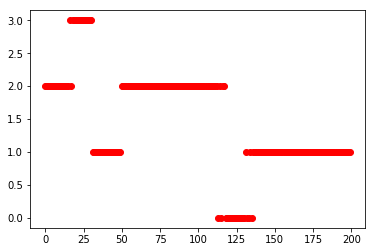

In [25]:
vv = v.mean(0).argmax(-1)
plt.plot(vv[:200].data.numpy(), 'ro')

(-3, 3)

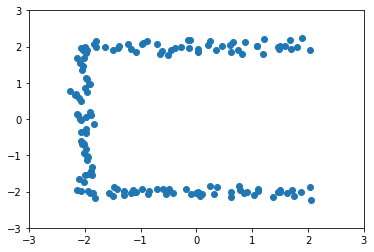

In [36]:
T = 150
plt.scatter(Xs[:T, 0].data.numpy(), Xs[:T, 1].data.numpy())
plt.xlim([-3,3])
plt.ylim([-3,3])

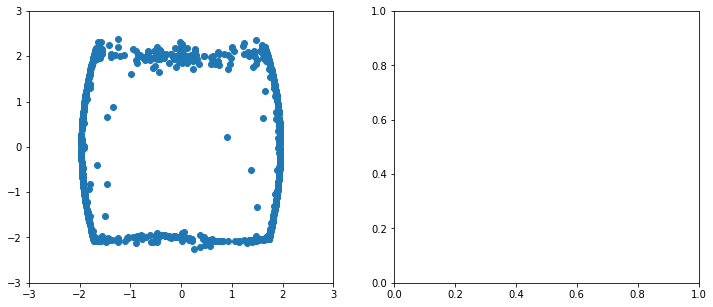

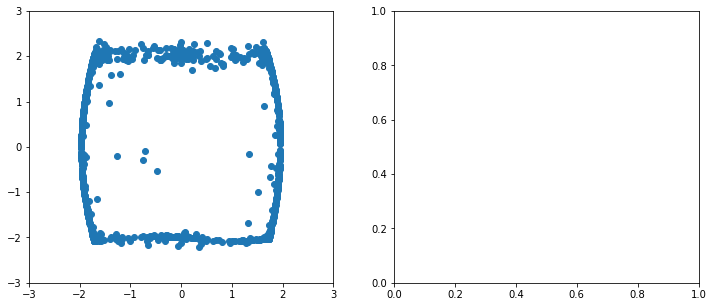

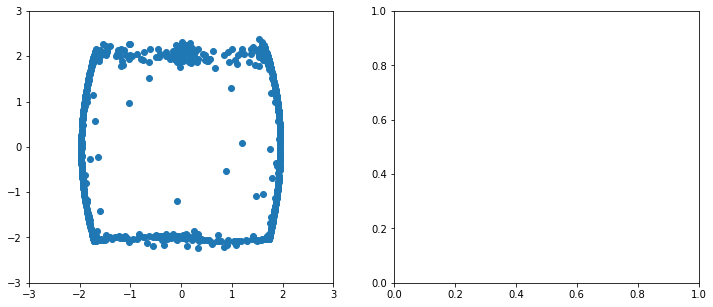

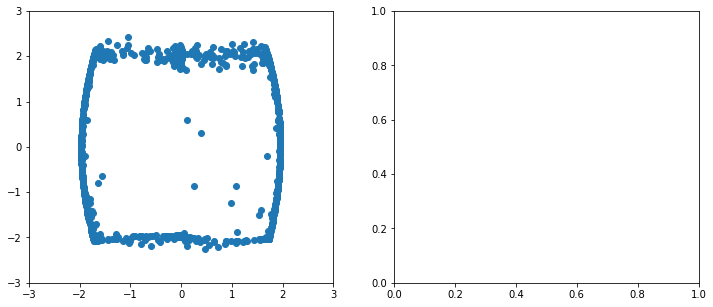

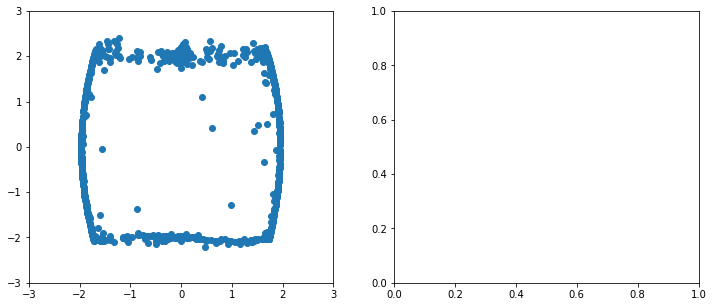

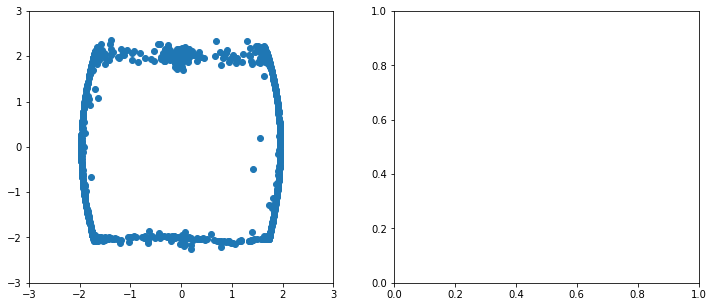

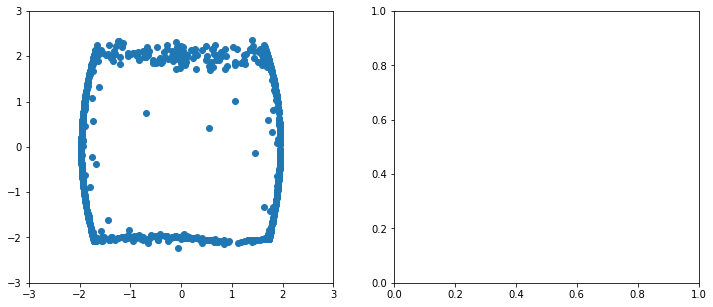

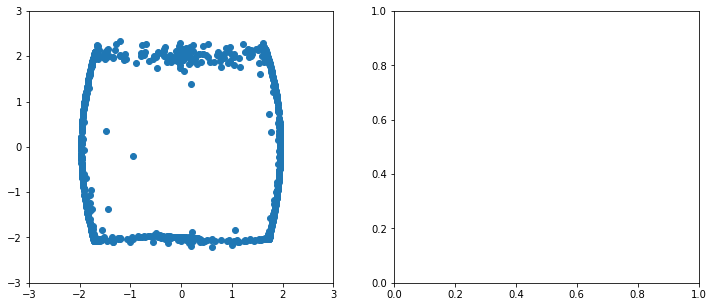

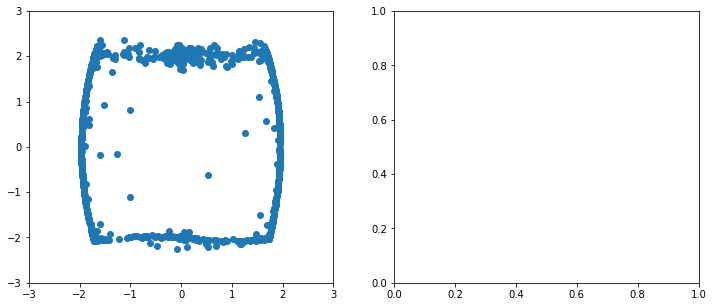

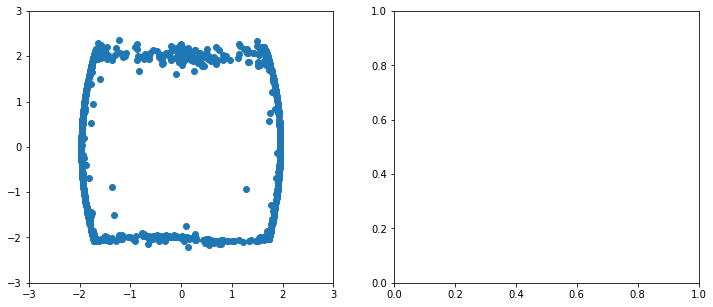

In [14]:
for s in range(NUM_SAMPLES):
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)   
    ax1.scatter(mu[s, :, 0].data.numpy(), mu[s, :, 1].data.numpy())
#     ax2.scatter(Xs_shuffle[:, 0].data.numpy(), Xs_shuffle[:, 1].data.numpy())
    ax1.set_xlim([-3,3])
    ax1.set_ylim([-3,3])


In [ ]:
a = torch.linspace(0.0, 0.2, 100)[:, None]
angles = dec.dec_angles(a) 
rads = dec.dec_rad(a)
x_mus = angles * rads

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(x_mus[:, 0].data.numpy(), x_mus[:, 1].data.numpy())
ax1.set_xlim([-3,3])
ax1.set_ylim([-3,3])